# Using CAPE ratios as market timing indicators

CAPE ratios are a valuation metric for the U.S. S&P 500 equity indexes, invented by Benjamin Graham and David Dodd and popularized by the behavioral economist and Nobel laureate Robert Shiller. It seeks to improve on the standard price-to-earnings ratio by using the moving ten-year inflation-adjusted earnings average instead, and thereby reducing the impacts of short-term market volatility. Higher CAPE ratios imply lower real returns _over the long term_. 

When the CAPE ratios climb, many people [get concerned about unsupportable valuations and the increased potential for stomach-churning drops] (http://www.cnbc.com/2015/09/03/risk-of-big-stock-drops-grows-robert-shiller.html). As I write this, we're in the mid-twenties, significantly above the long-term average of 17. (Though not so out of line with most of the post-2000 CAPE ratios, with the notable exception of the 2008 meltdown.) Still, Professor Shiller is careful to say that CAPE ratios aren't a short-term market timing tool.

But I am the kind of person who, when told, "do not use CAPE ratios as short-term market timing tool!" immediately wonders, "Huh. I wonder if I can use the CAPE ratios as a short-term market timing tool?"

Wouldn't it be great if there were some strategy where you sell when the CAPE ratio gets over _X_ and buy back in when it goes below _Y_ and beat the buy-and-hold performance? Fortunately, Professor Shiller makes [his data available](http://www.econ.yale.edu/~shiller/data.htm), so it's easy to find out.

## Download the data and load it into a DataFrame

We're using Python, and its very useful data analysis library [Pandas](http://pandas.pydata.org/). Its DataFrame structure is a natural for time series processing like this. We'll do some plotting, too; for that, we'll use the [matplotlib](http://matplotlib.org/) library. 

In [36]:
%matplotlib inline
import IPython.html.widgets as widgets
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import pandas as pd

pd.set_option('display.float_format', lambda x: '%.4f' % x)
pylab.rcParams['figure.figsize'] = 14, 8
pd.set_option('display.width', 400)

# load the CAPE data and clean it up a bit.
# source: http://www.econ.yale.edu/~shiller/data.htm
cape_data = pd.read_csv('CAPE data', skiprows=range(0,8), skip_blank_lines=True, \
                        names=['date','s&p comp price','s&p comp div','s&p comp earnings','CPI',\
                        'date fraction','int rate GS10','real price','real div','real earnings','CAPE','na'])
cape_data = cape_data[0:1737]
cape_data.sort('date',inplace=True)
cape_data.drop('na', axis=1,inplace=True)
cape_data.set_index('date')
cape_data[['s&p comp price', 'CPI', 'int rate GS10']] = cape_data[['s&p comp price', 'CPI','int rate GS10']].astype(float)

cape_data = cape_data.iloc[948:] # look at sample data since 1950

Let's see how the dataset is structured.

In [37]:
cape_data.head()

,date,s&p comp price,s&p comp div,s&p comp earnings,CPI,date fraction,int rate GS10,real price,real div,real earnings,CAPE
948,1950.0100,16.8800,1.1500,2.3400,23.5000,1950.0400,2.3200,171.4300,11.6800,23.7300,10.7500
949,1950.0200,17.2100,1.1600,2.3500,23.5000,1950.1200,2.3400,174.7800,11.7800,23.9000,10.9100
950,1950.0300,17.3500,1.1700,2.3700,23.6000,1950.2100,2.3600,175.4600,11.8300,23.9700,10.9100
951,1950.0400,17.8400,1.1800,2.4300,23.6000,1950.2900,2.3800,180.4200,11.9300,24.5400,11.1800
952,1950.0500,18.4400,1.1900,2.4800,23.7000,1950.3700,2.4000,185.7000,11.9800,25.0100,11.4600


Now let's plot the price, CAPE, and 1YPE data. We'll normalize the price data, adjusting for 2015 dollars and scaling it to make it readable next to the earnings ratios.

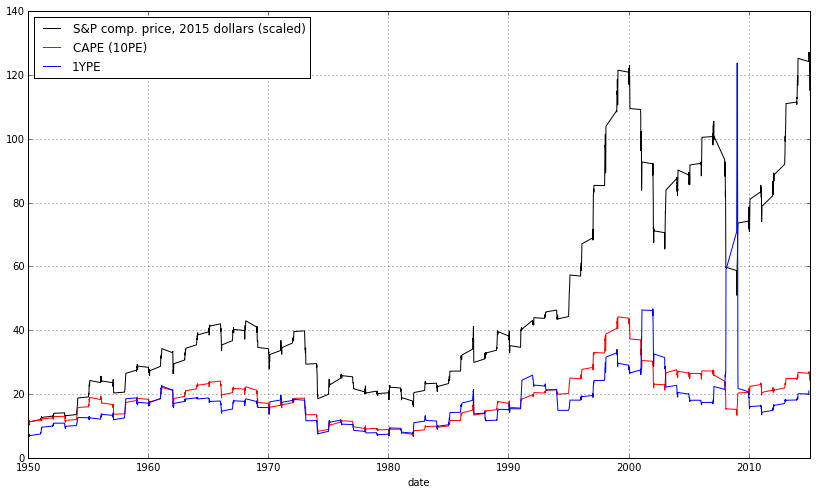

In [38]:
temp_df = cape_data.copy()

# create a column that holds the price in 2015 dollars
CPI2015 = temp_df.iloc[-1]['CPI']
temp_df['2015 price'] = temp_df['s&p comp price'] * ( CPI2015 / temp_df['CPI'] ) * .06
# ... and a column that holds the 1 year PE
temp_df['1PE'] = temp_df['s&p comp price'] / temp_df['s&p comp earnings'] 

# plot the price, CAPE, and 1Y PE
ax = temp_df.plot( x='date', y='2015 price', color='Black')
temp_df.plot( x='date',y='CAPE', color='Red', ax = ax )
temp_df.plot( x='date', y='1PE', color='Blue', ax=ax)
ax.legend(['S&P comp. price, 2015 dollars (scaled)','CAPE (10PE)','1YPE'], loc='upper left')

OK, time to write some code to test our sell- and buy-trigger hypothesis.

## Implement the core functions we'll be using

We'll need a split up the input data into two groups. The first group will hold all the periods where we have not hit our sell trigger and are invested in the market. The second group holds all the periods where we hit the sell trigger but have not yet hit our next buy trigger, and thus are not invested in the market.

In [39]:
def split_periods( sell_threshold, buy_threshold, df, debug=False ):
    """
    Given an input dataframe, return two lists of subset dataframes. In the first
    list are all the investable periods, and in the second list are the noninvestable
    periods. Investability is determined by CAPE ratio trigger values.
    
    Inputs:
    
        sell_threshold - the CAPE ratio point at which to end the investable period
        buy_threshold - the CAPE ratio at which to start the investable period
        df - the initial dataset with the CAPE ratio column
        debug - optional boolean for heavy debugging output
        
    Outputs:
    
        Returns two lists. The first is a list of subset dataframes that meet the investable
        period criteria, and second is a list of subset dataframes that don't meet the investable
        period critera.
    """
    
    invested_state = True
    invested_periods = list()
    noninvested_periods = list()
    current_period = list()
    # add an 'is invested' column
    df['is_invested'] = None
    
    for index, row in df.iterrows():
        if row['CAPE'] > sell_threshold and invested_state == True:
            # cape too high, cashing out. add the previous invested period to the invested periods list
            invested_state = False
            if debug:
                print "sell threshold, appending " + str( df.loc[ df['date'].isin( current_period) ] )
            invested_periods.append( df.loc[ df['date'].isin( current_period) ] )
            current_period = list()
        if row['CAPE'] < buy_threshold and invested_state == False:
            # cape low enough to buy back in. add the previous noninvested period to the noninvested periods list
            invested_state = True
            if debug:
                print "buy threshold, appending " + str( df.loc[ df['date'].isin( current_period) ] )
            noninvested_periods.append( df.loc[ df['date'].isin( current_period) ] )
            current_period = list()
        # set this row's 'is invested' state
        current_period.append( row['date'] )
        df.loc[index,'is_invested'] = invested_state
        
    # don't forget rows at the end of the dataset
    if invested_state == True:
        if debug:
            print "end of df: appending to invested: " + str( df.loc[ df['date'].isin( current_period) ] )
        invested_periods.append( df.loc[ df['date'].isin( current_period) ] )
    else:
        if debug:
            print "end of df: appending to noninvested: " + str( df.loc[ df['date'].isin( current_period) ] )
        noninvested_periods.append( df.loc[ df['date'].isin( current_period) ] )
    return (invested_periods,noninvested_periods)

For each investable period, we'll need to figure out the price gain or loss over that period. We'll be collecting dividends, so we'll add that into the total.

In [40]:
def compute_gain_or_loss( df ):
    '''
    compute the difference from the price in the first row to the price in the last row,
    adding in dividends for the total.
    '''
    if len(df) == 0:
        return 0.0
    divs = df['s&p comp div'] / 12   # dividends are annualized; break it down to months.
    divs_sum = divs.sum()
    if len(df) == 1:
        return divs_sum
    return df.iloc[-1]['s&p comp price'] - df.iloc[0]['s&p comp price'] + divs_sum

For each noninvestable period, we'll be parking our money in a safe short-term interest bearing account. We'll write a function to calculate that amount.

In [41]:
def compute_interest( df ):
    '''
    for the time period in the dataframe, compute the interest that would be accrued
    '''
    intr = df['int rate GS10'] / 12         # to get monthly gs10 interest rate
    intr = intr / 10                        # to approximate short term interest rate
    return intr.sum()

Compute_passive_gains() calculates the gains for the baseline buy-and-hold case. It returns the change in price plus the dividends over the entire time period.

Compute_cape_strategy_gains() splits the input data into investable and noninvestable periods, based on its sell and buy thresholds given as parameters. For each of the investable periods, it computes the gain or loss plus the dividends. For each of the noninvestable periods, it computes the interest accrued. It sums these together and returns this as the total gain for the CAPE strategy.

In [42]:
def compute_passive_gains( df ):
    '''
    compute the total gains or losses for the dataframe
    '''
    gains_list = map( compute_gain_or_loss, [ df, ] )
    return sum(gains_list)

def compute_cape_strategy_gains( sell_threshold, buy_threshold, df, debug = False ):
    '''
    compute the total gains and losses for the dataframe, using the sell and buy thresholds
    to time the investable periods
    '''
    # split the dataframe into invested and noninvested periods, using the thresholds
    (invested_periods,noninvested_periods) = split_periods(sell_threshold, buy_threshold, df, debug ) 
    if debug:
        print "\n\n===cape invested periods" + str(invested_periods) + "\n===="
        print "\n\n===cape noninvested periods " + str(noninvested_periods) + "\n===="
    # compute the gain or loss for each invested period
    gain_list = map( compute_gain_or_loss, invested_periods )
    # compute the interest accrued for each noninvested period
    int_list = map( compute_interest, noninvested_periods )
    return sum(gain_list) + sum(int_list)

## Do the calculations

We calculate the baseline buy-and-hold case, and then loop through a range of possible sell and buy threshold values for the CAPE strategy. We store the difference between the baseline gain and the CAPE strategy in a DataFrame. A positive number means you do better with buy-and-hold than with the given CAPE strategy; a negative number means the CAPE strategy wins.

In [43]:
sample_df = cape_data.copy()
results = []

# compute the buy and hold results
baseline_gains = compute_passive_gains( sample_df )

# compute the CAPE strategy results for various sell and buy thresholds
for s in range(20,50):
    for b in range( 10, 30 ):
        if b > s: continue
        cape_gains = compute_cape_strategy_gains( s, b, sample_df )
        results.append( [ baseline_gains - cape_gains, s, b ] )
        
results_df = pd.DataFrame( data=results, columns=['baseline - cape return', 'sell threshold', 'buy threshold'])

## Plot the results

Now we plot the results.

The axes indicate the sell and buy threshold parameters tested with the cape strategy. The dots tell you how the test came out: blue means buy-and-hold wins, and red means the CAPE strategy wins. The size of the dot gives you a relative indicator of how much winning is going on; the bigger the dot, the bigger the win.

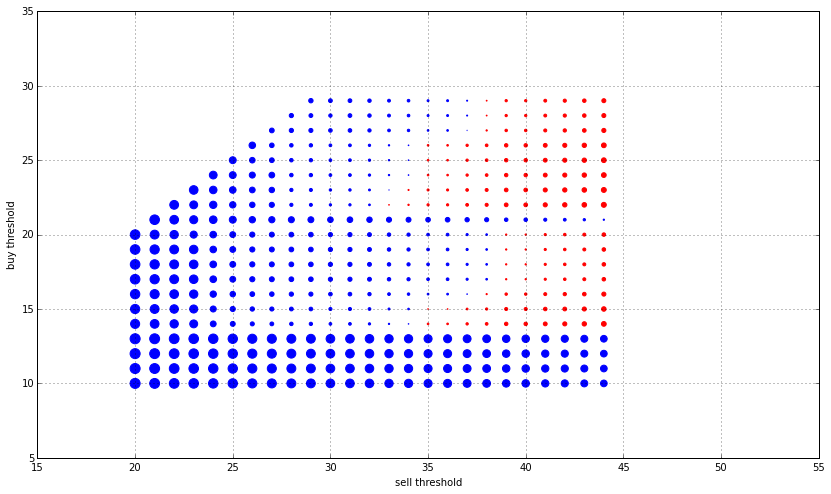

In [44]:
baseline_df = results_df[ results_df['baseline - cape return'] > 0 ]
ax = baseline_df.plot(kind='scatter', x='sell threshold',y='buy threshold', \
                color='Blue', s = baseline_df['baseline - cape return'] * .05)

cape_df = results_df[ results_df['baseline - cape return'] <= 0 ]
cape_df.plot(kind='scatter', x='sell threshold',y='buy threshold', \
                color='Red', s = cape_df['baseline - cape return'] * -.05 , ax = ax )

What this tells me is that you can use the CAPE ratio to beat buy-and-hold -- but only when it's very, very high. Which isn't terribly often: the CAPE ratio has been over 35 4.3% of the 1950-2015 timeframe, all of it during the dotcom boom of 1998-2001.

Looking at other stock market debacles, Black Tuesday's 1929 CAPE ratio was around 30, and Black Monday's 1987 CAPE ratio was in the high teens. When we look at the plot, we see that buy-and-hold easily beats a CAPE strategy that uses either of those numbers as sell triggers.

You see where I'm going with this, right? CAPE ratios are not, in fact, useful market timing tools. Also, it's really, really, really hard to beat buy-and-hold. Really. Effin. Hard.

### Appendix: further reading

Professor Shiller's most well-known popular book is [Irrational Exuberance](http://www.amazon.com/Irrational-Exuberance-Robert-J-Shiller-ebook/dp/B00P6ZJ6HC/ref=mt_kindle?_encoding=UTF8&me=), where he describes his theory of behavioral economics and asset bubbles in particular.

Professor Shiller was a fascinating interviewee on Barry Ritholtz's [Masters in Business](http://www.bloombergview.com/articles/2014-11-24/barry-ritholtzs-masters-in-business-the-robert-shiller-interview) podcast.

### Appendix: tests

In [45]:
# import and options
%matplotlib inline
import IPython.html.widgets as widgets
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import pandas as pd

pd.set_option('display.float_format', lambda x: '%.4f' % x)
pylab.rcParams['figure.figsize'] = 14, 8
pd.set_option('display.width', 400)

# read in test file for tests 1 and 2
test_data = pd.read_csv('testdata.csv', skiprows=range(0,8), skip_blank_lines=True, \
                        names=['date','s&p comp price','s&p comp div','s&p comp earnings','CPI',\
                        'date fraction','int rate GS10','real price','real div','real earnings','CAPE','na'])
test_data.drop('na', axis=1,inplace=True)
test_data.sort('date', inplace=True)
test_data.set_index('date')

#############################
#
# test 1
#
#############################
print "\n\ntest 1: baseline and cape strategies are the same"
sample_df = test_data.copy()
results = []

baseline_gains = compute_passive_gains( sample_df )
print "baseline gains " + str(baseline_gains)
assert baseline_gains == 1012.0

print "doing cape computation now"
sell_threshold = 25.0
buy_threshold = 20.0
cape_gains = compute_cape_strategy_gains( sell_threshold, buy_threshold, sample_df )
print "cape_gains " + str(cape_gains)
assert cape_gains == 1012.0
results.append( [ baseline_gains - cape_gains, sell_threshold, buy_threshold ] )
        
results_df = pd.DataFrame( data=results, columns=['baseline - cape return', 'sell threshold', 'buy threshold'])
assert len(results_df) == 1
assert results_df.iloc[0]['baseline - cape return'] == 0.0
assert results_df.iloc[0]['sell threshold'] == sell_threshold
assert results_df.iloc[0]['buy threshold'] == buy_threshold
print "test 1 passed"

#############################
#
# test 2
#
#############################
print "\n\ntest 2: cape strategy always in cash"
sample_df = test_data.copy()
results = []

baseline_gains = compute_passive_gains( sample_df )
print "baseline gains " + str(baseline_gains)
assert baseline_gains == 1012.0

print "doing cape computation now"
sell_threshold = 15.0
buy_threshold = 10.0
cape_gains = compute_cape_strategy_gains( sell_threshold, buy_threshold, sample_df )
print "cape_gains " + str(cape_gains)
assert cape_gains == 0.6
results.append( [ baseline_gains - cape_gains, sell_threshold, buy_threshold ] )
        
results_df = pd.DataFrame( data=results, columns=['baseline - cape return', 'sell threshold', 'buy threshold'])
assert len(results_df) == 1
assert results_df.iloc[0]['baseline - cape return'] == 1011.4
assert results_df.iloc[0]['sell threshold'] == sell_threshold
assert results_df.iloc[0]['buy threshold'] == buy_threshold
print "test 2 passed"

# read in test file for test 3
test_data = pd.read_csv('testdata2.csv', skiprows=range(0,8), skip_blank_lines=True, \
                        names=['date','s&p comp price','s&p comp div','s&p comp earnings','CPI',\
                        'date fraction','int rate GS10','real price','real div','real earnings','CAPE','na'])
test_data.drop('na', axis=1,inplace=True)
test_data.sort('date', inplace=True)
test_data.set_index('date')

#############################
#
# test 3
#
#############################
print "\n\ntest 3: cape strategy sometimes in cash"
sample_df = test_data.copy()
results = []

baseline_gains = compute_passive_gains( sample_df )
print "baseline gains " + str(baseline_gains)
assert baseline_gains == 12.0

print "doing cape computation now"
sell_threshold = 22.0
buy_threshold = 21.0
cape_gains = compute_cape_strategy_gains( sell_threshold, buy_threshold, sample_df, debug = True )
print "cape_gains " + str(cape_gains)
assert cape_gains == 1008.20
results.append( [ baseline_gains - cape_gains, sell_threshold, buy_threshold ] )
        
results_df = pd.DataFrame( data=results, columns=['baseline - cape return', 'sell threshold', 'buy threshold'])
assert len(results_df) == 1
assert results_df.iloc[0]['baseline - cape return'] == -996.2
assert results_df.iloc[0]['sell threshold'] == sell_threshold
assert results_df.iloc[0]['buy threshold'] == buy_threshold
print "test 3 passed"




test 1: baseline and cape strategies are the same
baseline gains 1012.0
doing cape computation now
cape_gains 1012.0
test 1 passed


test 2: cape strategy always in cash
baseline gains 1012.0
doing cape computation now
cape_gains 0.6
test 2 passed


test 3: cape strategy sometimes in cash
baseline gains 12.0
doing cape computation now
sell threshold, appending Empty DataFrame
Columns: [date, s&p comp price, s&p comp div, s&p comp earnings, CPI, date fraction, int rate GS10, real price, real div, real earnings, CAPE, is_invested]
Index: []
buy threshold, appending        date  s&p comp price  s&p comp div  s&p comp earnings      CPI  date fraction  int rate GS10  real price  real div  real earnings    CAPE is_invested
3 2009.0100       1000.0000       12.0000            25.3500 216.1770      2009.7900         6.0000   1178.7300   25.8400        27.9900 25.0000       False
4 2009.0200       2000.0000       12.0000            25.3500 216.1770      2009.7900         6.0000   1178.7300   